In [36]:
# Adjusting the code to print out the corresponding returns for the winner, loser, and winner minus loser portfolios.

import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp 

# Load the data
data_path = ''  # Update the path according to your environment
df = pd.read_excel(data_path, index_col=0) 


# Function to calculate logarithmic returns
def calculate_returns(df, weeks):
    return np.log(df / df.shift(weeks))

# Function to execute the momentum strategy with overlapping periods
def momentum_strategy_overlapping(df, observation_weeks, holding_weeks):
    
    weekly_returns = calculate_returns(df, 1)
    
    # Lists to store returns for winners, losers, and their difference
    winner_returns_list = [] 
    loser_returns_list = []
    winner_minus_loser_returns_list = []  
    combo_returns_list = [] 

    
    total_periods = len(df) - observation_weeks - holding_weeks + 1 
    
    for period_start in range(total_periods):
        # Observation period returns
        observation_period = weekly_returns.iloc[period_start:period_start + observation_weeks] 
        
        # Mean returns during the observation period
        mean_observation_returns = observation_period.mean()  
        
        # Select winners and losers
        winners = mean_observation_returns.nlargest(3).index 
        losers = mean_observation_returns.nsmallest(3).index 
        
        # Holding period returns
        holding_period = weekly_returns.iloc[period_start + observation_weeks:period_start + observation_weeks + holding_weeks] 
        
        # Calculate returns for the winners and losers
        winner_returns = holding_period[winners].mean(axis=1)  
        loser_returns = holding_period[losers].mean(axis=1) 
        market_returns = holding_period['上证综指'].mean() 
        
        # Calculate excess returns for winners and negative losers over market
        winner_excess_returns = winner_returns - market_returns 
        loser_excess_returns = loser_returns - market_returns 
        winner_minus_loser_returns = winner_returns - loser_returns 
        combo_returns = winner_returns - loser_returns - market_returns 
        
        # Store the returns
        winner_returns_list.extend(winner_excess_returns) 
        loser_returns_list.extend(loser_excess_returns)
        winner_minus_loser_returns_list.extend(winner_minus_loser_returns)
        combo_returns_list.extend(combo_returns) 

    # Perform t-tests
    winner_over_market_pvalue = ttest_1samp(winner_returns_list, 0).pvalue
    loser_over_market_pvalue = ttest_1samp(loser_returns_list, 0).pvalue
    winner_minus_loser_pvalue = ttest_1samp(winner_minus_loser_returns_list, 0).pvalue 
    combo_pvalue = ttest_1samp(combo_returns_list, 0).pvalue 

    # Returns the p-values and the average returns
    return (winner_over_market_pvalue, np.mean(winner_returns_list),
            loser_over_market_pvalue, np.mean(loser_returns_list),
            winner_minus_loser_pvalue, np.mean(winner_minus_loser_returns_list),
            combo_pvalue, np.mean(combo_returns_list))  

# Applying the strategy for the specified observation and holding periods
observation_periods = [1, 2, 3, 4,5,6,7,8] 
holding_periods = [1, 2, 3, 4,5,6,7,8] 

In [37]:

results_df = pd.DataFrame()


for observation in observation_periods:
    for holding in holding_periods:
       
        p_value_winner_market, avg_return_winner, \
        p_value_loser_market, avg_return_loser, \
        p_value_winner_loser, avg_return_winner_loser,\
        p_value_combo, avg_return_combo= momentum_strategy_overlapping(df, observation, holding)
        
        
        current_results = pd.DataFrame({
            'Observation Period': [observation],  
            'Holding Period': [holding], 
            'Winner over Market p-value': [p_value_winner_market], 
            'Winner over Market Return': [avg_return_winner],  
            'Loser over Market p-value': [p_value_loser_market], 
            'Loser over Market Return': [avg_return_loser],  
            'Winner minus Loser p-value': [p_value_winner_loser],
            'Winner minus Loser Return': [avg_return_winner_loser], 
            'combo p-value': [p_value_combo], 
            'combo Return': [avg_return_combo] 
        })

        
        
        results_df = pd.concat([results_df, current_results], ignore_index=True)


print(results_df)


    Observation Period  Holding Period  Winner over Market p-value  \
0                    1               1                    0.037318   
1                    1               2                    0.046896   
2                    1               3                    0.010044   
3                    1               4                    0.007362   
4                    1               5                    0.006051   
..                 ...             ...                         ...   
59                   8               4                    0.063280   
60                   8               5                    0.063378   
61                   8               6                    0.042468   
62                   8               7                    0.015804   
63                   8               8                    0.009106   

    Winner over Market Return  Loser over Market p-value  \
0                    0.002408                   0.896431   
1                    0.001906          

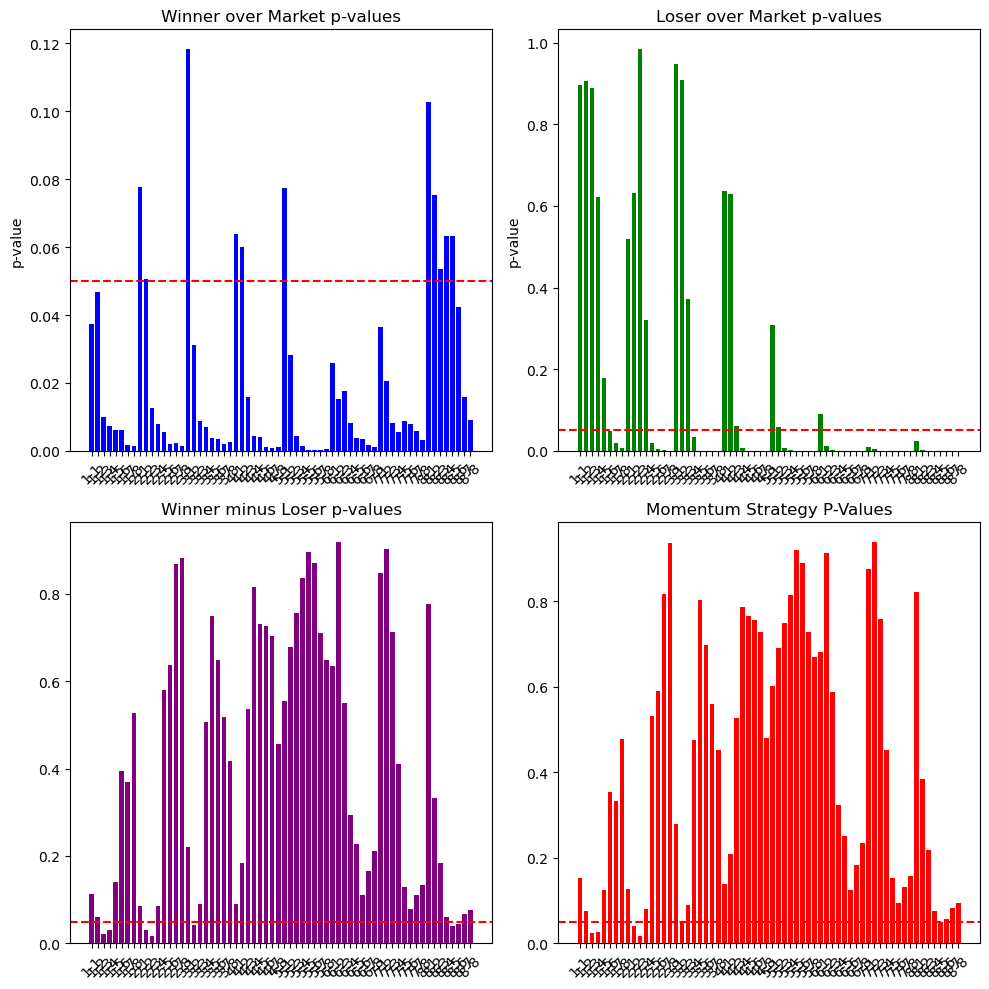

In [38]:
import matplotlib.pyplot as plt


winner_market_p_values = results_df['Winner over Market p-value'] 
loser_market_p_values = results_df['Loser over Market p-value'] 
winner_loser_p_values = results_df['Winner minus Loser p-value'] 
combo_p_values = results_df['combo p-value'] 


plt.figure(figsize=(10, 10)) 


plt.subplot(2, 2, 1) 
plt.bar(range(len(winner_market_p_values)), winner_market_p_values, color='blue') 
plt.xticks(range(len(winner_market_p_values)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45)
plt.axhline(y=0.05, color='red', linestyle='--')  
plt.title('Winner over Market p-values') 
plt.ylabel('p-value') 

plt.subplot(2, 2, 2) 
plt.bar(range(len(loser_market_p_values)), loser_market_p_values, color='green') 
plt.xticks(range(len(loser_market_p_values)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45)
plt.axhline(y=0.05, color='red', linestyle='--')  
plt.title('Loser over Market p-values') 
plt.ylabel('p-value') 

plt.subplot(2, 2, 3) 
plt.bar(range(len(winner_loser_p_values)), winner_loser_p_values, color='purple') 
plt.xticks(range(len(winner_loser_p_values)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45)
plt.axhline(y=0.05, color='red', linestyle='--') 
plt.title('Winner minus Loser p-values') 


plt.subplot(2, 2, 4) 
plt.bar(range(len(combo_p_values)), combo_p_values, color='red') 
plt.xticks(range(len(combo_p_values)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45)
plt.axhline(y=0.05, color='red', linestyle='--') 
plt.title('Momentum Strategy P-Values') 


plt.tight_layout() 
plt.show() 


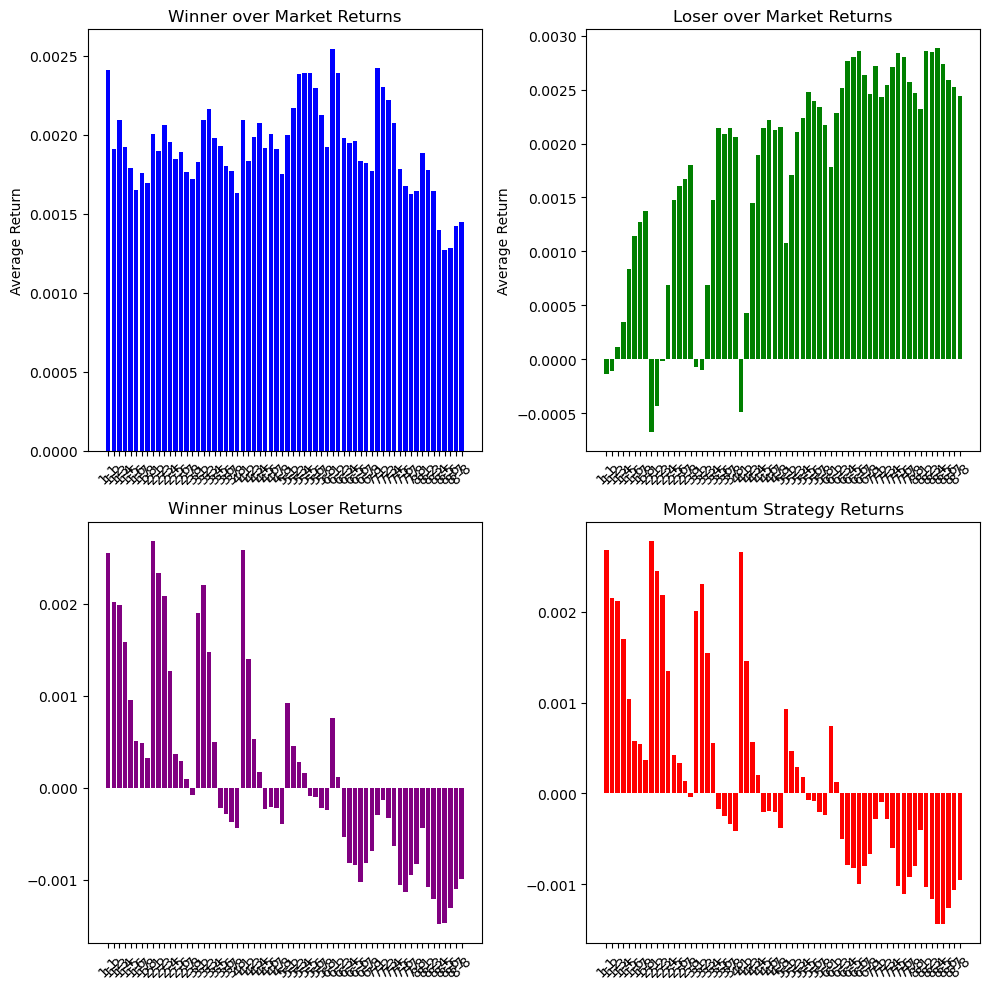

In [39]:

winner_market_returns = results_df['Winner over Market Return'] 
loser_market_returns = results_df['Loser over Market Return']
winner_loser_returns = results_df['Winner minus Loser Return']
combo_returns = results_df['combo Return'] 


plt.figure(figsize=(10, 10)) 


plt.subplot(2, 2, 1) 
plt.bar(range(len(winner_market_returns)), winner_market_returns, color='blue') 
plt.xticks(range(len(winner_market_returns)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45) # 设置x轴刻度标签，显示观察期-持有期，并旋转45度以改善可读性
plt.title('Winner over Market Returns') 
plt.ylabel('Average Return') 

plt.subplot(2, 2, 2) 
plt.bar(range(len(loser_market_returns)), loser_market_returns, color='green') 
plt.xticks(range(len(loser_market_returns)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45) # 设置x轴刻度标签，显示观察期-持有期，并旋转45度以改善可读性
plt.title('Loser over Market Returns') 
plt.ylabel('Average Return') 

plt.subplot(2, 2, 3) 
plt.bar(range(len(winner_loser_returns)), winner_loser_returns, color='purple') 
plt.xticks(range(len(winner_loser_returns)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45) # 设置x轴刻度标签
plt.title('Winner minus Loser Returns')


plt.subplot(2, 2, 4) 
plt.bar(range(len(combo_returns)), combo_returns, color='red') 
plt.xticks(range(len(combo_returns)), [f'{op}-{hp}' for op, hp in zip(results_df['Observation Period'], results_df['Holding Period'])], rotation=45)
plt.title('Momentum Strategy Returns')

plt.tight_layout() 
plt.show() 
